### Libraries

In [ ]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/gdrive', force_remount=True)
check = Path.cwd()/'gdrive/MyDrive/TMProject'
files = list(check.glob("**/*.npy"))

Mounted at /content/gdrive


In [ ]:
!pip install datasets

     |████████████████████████████████| 306 kB 5.2 MB/s 
     |████████████████████████████████| 61 kB 437 kB/s 
     |████████████████████████████████| 243 kB 55.9 MB/s 
     |████████████████████████████████| 1.1 MB 54.1 MB/s 
     |████████████████████████████████| 132 kB 55.1 MB/s 
     |████████████████████████████████| 271 kB 38.3 MB/s 
     |████████████████████████████████| 160 kB 65.1 MB/s 
     |████████████████████████████████| 192 kB 73.7 MB/s 


In [ ]:
# Data Manipultion
import numpy as np
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display
from tqdm import tqdm

# OS
from pathlib import Path
import glob
from joblib import dump, load

# ML
# from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
# DL

# NLP
from datasets import load_dataset, list_datasets

### Helper Functions

In [ ]:
def get_data(*args, **kwargs):
    """Function to load Reuters data using HuggingFace API."""
    reuters = load_dataset("reuters21578","ModApte") # ModApte b'coz of "A re-examination of text categorization methods" paper
    train = reuters['train'] # Same as paper
    test = reuters['test'] # Same as paper
    train.set_format(type = "pandas")
    test.set_format(type = "pandas")   
    df_train = train[:]
    df_test = test[:]
    # Get empty Indexes: required for dealing with Tensored datasets
    empty_train = df_train.index[df_train.topics.str.len().eq(0)] 
    empty_test = df_test.index[df_test.topics.str.len().eq(0)]

    df_train = df_train[~df_train.topics.str.len().eq(0)] # Drop Empty Topics
    df_test = df_test[~df_test.topics.str.len().eq(0)] # Drop Empty Topics
    cols =df_train.columns

    df_train = df_train.drop([col for col in cols if col not in ['text', 'topics']], axis=1)
    df_test = df_test.drop([col for col in cols if col not in ['text', 'topics']], axis=1)

    X_train = df_train['text']
    X_test = df_test['text']
    mlb = MultiLabelBinarizer()
    y_train = mlb.fit_transform(df_train.topics)
    y_test = mlb.transform(df_test.topics)
    print("Use different yTest and yTrain for BERT model")
    return X_train,X_test,y_train,y_test, empty_train,empty_test

def get_from_colab(check,name):
    return np.load(f"{check}/{name}.npy")

def spacy_tokenizer(text):
    """SpaCy Tokenizer pipeline"""
    doc = nlp(text, disable=['ner', 'tagger', 'parser'])
    return [token.text for token in doc if not token.is_stop and not token.is_punct]

def allDone():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))


######
def model_eval(actual,predicted,score,*args,**kwargs):
    model_score = score(actual,predicted,*args,**kwargs)
    return model_score
def hypothesis_test(dx_i,dx, significance=0.05, hypothesis=""):
    """
    Implementation of paired-bootstrap test.
    Reference: Berg-Kirkpatrick, et. al. "An empirical investigation of statistical significance in nlp."
    """
    p_value = np.mean(dx_i>= (2*dx))
    diff = np.quantile(dx_i, q=(0.025,0.975))
    
    print("\n")
    if p_value<significance:
        
        print(f"We reject the null hypothesis for {hypothesis} at a significance of {significance} at p-value: {p_value}")

    else:
        print(f"We fail to reject the Null Hypothesis {hypothesis} at a significance of {significance} at p-value: {p_value}")
    print(f"95% CI of delta: {diff}")
    print("#"*10)

def paired_bootstrap_test(test_set, model1,model2, B, *args,**kwargs):
    """
    Function to generate \delta(x) and \delta(x^{(i)}) for B bootstrap samples.
    Reference: 
        Jurafsky, Daniel, and James H. Martin. "Speech and Language Processing: An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition."
    Params:
    ------
    test_set: np.ndarray, Array of test outputs.
    model1: np.ndarray, Array of Model A's output.
    model2: np.ndarray, Array of Model B's output.
    B : int, No of Bootstrap's to be generated
    score: Evaluation algorithm.
    """
    N = test_set.shape[0]
    p1,r1,f1_1,_=  precision_recall_fscore_support(test_set, model1, *args,**kwargs)
    p2,r2,f1_2,_ =  precision_recall_fscore_support(test_set, model2, *args,**kwargs)
    delta_precision =  p1-p2 #\delta(x)
    delta_recall = r1-r2
    delta_f1 = f1_1-f1_2
    deltas_p = np.zeros(B) # for storing \delta(X) of bootstraps
    deltas_r =  np.zeros(B)
    deltas_f1 =  np.zeros(B)
    indexes = np.random.randint(low=0, high=N, size=(B,N))
    for boot in tqdm(range(B)):
        
        sampleY = test_set[indexes[boot,:],:]
        sample1 = model1[indexes[boot,:],:]
        model1_p, model1_r,model1_f1,_ = precision_recall_fscore_support(sampleY, sample1,*args,**kwargs)
        sample2 = model2[indexes[boot,:],:]
        model2_p,model2_r,model2_f1,_ = precision_recall_fscore_support(sampleY, sample2, *args, **kwargs)
        # delta_b = sc1 - sc2
        delta_p_boot = model1_p-model2_p
        delta_r_boot = model1_r - model2_r
        delta_f1_boot = model1_f1 - model2_f1

        deltas_p[boot] = delta_p_boot
        deltas_r[boot] = delta_r_boot
        deltas_f1[boot] = delta_f1_boot

    for hype in ['precision', 'recall', 'f1']:
        if hype =="precision":
            hypothesis_test(deltas_p,delta_precision, significance=0.05, hypothesis=hype)
        if hype=='recall':
            hypothesis_test(deltas_r,delta_recall, significance=0.05, hypothesis=hype)
        if hype == "f1":
            hypothesis_test(deltas_f1,delta_f1, significance=0.05, hypothesis=hype)
    # return (deltas, delta)


    # return p_value

### Datat Loading

In [ ]:
xtrain,xtest,ytrain,ytest,_,_ = get_data()

Downloading:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.15M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset reuters21578 downloaded and prepared to /root/.cache/huggingface/datasets/reuters21578/ModApte/1.0.0/98a2ad6a0242627562db83992f9625261854c40a88619322596153a5a16a206c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Use different yTest and yTrain for BERT model


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) ['cottonseed', 'f-cattle', 'sfr'] will be ignored
  "unknown class(es) {0} will be ignored".format(sorted(unknown, key=str))


In [ ]:
ytrain.shape,xtest.shape

((7775, 115), (3019,))

In [ ]:
# save data

# xtrain,xtest,ytrain,ytest, empty_train,empty_test = get_data()

## For BERT
ytrain_bert_idx  = get_from_colab(check, 'tuned_bert_original_train_idx')
ytest_bert_idx = get_from_colab(check, 'tuned_bert_original_test_idx')
## train 
ytrain_dummy = np.load(f"{check}/ytrain_dummy.npy")
ytrain_nb = np.load(f"{check}/naive_bayes_train.npy")
ytrain_knn = np.load(f"{check}/knn_train.npy")
ytrain_svm = np.load(f"{check}/svm_train.npy")
ytrain_nn = get_from_colab(check,'nn_train')
ytrain_dt = get_from_colab(check, 'ytrain_dt')
ytrain_rf = get_from_colab(check, 'ytrain_rf')
ytrain_adab = get_from_colab(check, 'ytrain_adab')
ytrain_bert = get_from_colab(check, 'tuned_bert_output_train')


## test
ytestdummy = np.load(f"{check}/ytest_dummy.npy")

ytest_nb = np.load(f"{check}/naive_bayes.npy")

ytest_knn = np.load(f"{check}/knn.npy")

ytest_svm = np.load(f"{check}/svm.npy")

ytest_nn = get_from_colab(check,'nn')

ytest_dt = get_from_colab(check, 'ytest_dt')

ytest_rf = get_from_colab(check, 'ytest_rf')

ytest_adab = get_from_colab(check, 'ytest_adab')

ytest_pred_bert = get_from_colab(check, 'tuned_bert_output_test')
# test outputs
model_test_result = (ytestdummy,ytest_nb,ytest_knn, ytest_svm, ytest_nn, ytest_dt, ytest_rf, ytest_adab)
# print(ytest_pred_bert.shape)


# Evaluation

- miP
- miR
- miF1

In [ ]:
# f1_score(ytrain[ytrain_bert_idx,:], ytrain_bert, average='micro', zero_division=True)

## Paired Bootstrap Test

In [ ]:
bootstrap_samples = 10_000

### Comparing with Baseline

## miP

In [ ]:
# for output in model_test_result[1:]: # Leaving dummy model.
paired_bootstrap_test(ytest, ytest_nb, ytest_svm ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:38<00:00, 10.13it/s]



We reject the null hypothesis for precision at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.04101657 0.0587549 ]
##########


We fail to reject the Null Hypothesis recall at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.36788786 -0.33226501]
##########


We fail to reject the Null Hypothesis f1 at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.29676856 -0.26396608]
##########


In [ ]:
paired_bootstrap_test(ytest, ytest_nb, ytest_nn ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:40<00:00,  9.92it/s]



We reject the null hypothesis for precision at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.04305397 0.0622237 ]
##########


We fail to reject the Null Hypothesis recall at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.31090009 -0.2762558 ]
##########


We fail to reject the Null Hypothesis f1 at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.25782716 -0.22641202]
##########


In [ ]:
paired_bootstrap_test(ytest, ytest_nb, ytest_rf ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:37<00:00, 10.24it/s]



We reject the null hypothesis for precision at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.0413531 0.0631767]
##########


We fail to reject the Null Hypothesis recall at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.15341721 -0.12839884]
##########


We fail to reject the Null Hypothesis f1 at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.13736424 -0.11220289]
##########


In [ ]:
paired_bootstrap_test(ytest, ytest_nb, ytest_adab ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:38<00:00, 10.17it/s]



We reject the null hypothesis for precision at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.24393054 0.27785601]
##########


We fail to reject the Null Hypothesis recall at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.22573748 -0.19757789]
##########


We fail to reject the Null Hypothesis f1 at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.1255754  -0.09865581]
##########


In [ ]:
paired_bootstrap_test(ytest[ytest_bert_idx,:], ytest_nb[ytest_bert_idx,:], ytest_pred_bert ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:40<00:00,  9.93it/s]



We reject the null hypothesis for precision at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.08121967 0.1058135 ]
##########


We fail to reject the Null Hypothesis recall at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.33874485 -0.3060979 ]
##########


We fail to reject the Null Hypothesis f1 at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.26208727 -0.23018825]
##########


#### KNN

In [ ]:
paired_bootstrap_test(ytest[ytest_bert_idx,:], ytest_knn[ytest_bert_idx,:], ytest_pred_bert ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:41<00:00,  9.89it/s]



We reject the null hypothesis for precision at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.08136087 0.10621859]
##########


We fail to reject the Null Hypothesis recall at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.54830962 -0.51255912]
##########


We fail to reject the Null Hypothesis f1 at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.52884145 -0.49388768]
##########


In [ ]:
paired_bootstrap_test(ytest, ytest_knn, ytest_svm ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:38<00:00, 10.15it/s]



We reject the null hypothesis for precision at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.03962158 0.05873186]
##########


We fail to reject the Null Hypothesis recall at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.57863643 -0.54008625]
##########


We fail to reject the Null Hypothesis f1 at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.56513803 -0.52709027]
##########


In [ ]:
paired_bootstrap_test(ytest, ytest_knn, ytest_nn ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:39<00:00, 10.07it/s]



We reject the null hypothesis for precision at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.04098503 0.06252391]
##########


We fail to reject the Null Hypothesis recall at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.52164937 -0.48448099]
##########


We fail to reject the Null Hypothesis f1 at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.52544596 -0.4887949 ]
##########


In [ ]:
paired_bootstrap_test(ytest, ytest_knn, ytest_dt ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:39<00:00, 10.03it/s]



We reject the null hypothesis for precision at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.3911227  0.43718727]
##########


We fail to reject the Null Hypothesis recall at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.44110997 -0.40630555]
##########


We fail to reject the Null Hypothesis f1 at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.33086919 -0.29113616]
##########


In [ ]:
paired_bootstrap_test(ytest, ytest_knn, ytest_rf ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:38<00:00, 10.15it/s]



We reject the null hypothesis for precision at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.03922137 0.0636533 ]
##########


We fail to reject the Null Hypothesis recall at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.36883908 -0.33411093]
##########


We fail to reject the Null Hypothesis f1 at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.40910972 -0.37320839]
##########


In [ ]:
paired_bootstrap_test(ytest, ytest_knn, ytest_adab ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:38<00:00, 10.10it/s]



We reject the null hypothesis for precision at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.24352439 0.27996   ]
##########


We fail to reject the Null Hypothesis recall at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.43944785 -0.40497464]
##########


We fail to reject the Null Hypothesis f1 at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.39683331 -0.36057304]
##########


### SVM

In [ ]:
paired_bootstrap_test(ytest[ytest_bert_idx,:], ytest_svm[ytest_bert_idx,:], ytest_pred_bert ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:41<00:00,  9.87it/s]




We reject the null hypothesis for precision at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.03155273 0.05680762]
##########


We reject the null hypothesis for recall at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.01636882 0.0386048 ]
##########


We reject the null hypothesis for f1 at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.02498089 0.04348081]
##########


In [ ]:
paired_bootstrap_test(ytest, ytest_svm, ytest_nn ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:40<00:00,  9.99it/s]



We fail to reject the Null Hypothesis precision at a significance of 0.05 at p-value: 0.25
95% CI of delta: [-0.00437208  0.00948478]
##########


We reject the null hypothesis for recall at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.04721214 0.06638168]
##########


We reject the null hypothesis for f1 at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.03194841 0.04603829]
##########


In [ ]:
paired_bootstrap_test(ytest, ytest_svm, ytest_dt ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:38<00:00, 10.11it/s]



We reject the null hypothesis for precision at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.34382118 0.3896514 ]
##########


We reject the null hypothesis for recall at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.12046164 0.14963824]
##########


We reject the null hypothesis for f1 at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.22046384 0.24965778]
##########


In [ ]:
paired_bootstrap_test(ytest, ytest_svm, ytest_rf ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:38<00:00, 10.14it/s]



We fail to reject the Null Hypothesis precision at a significance of 0.05 at p-value: 0.332
95% CI of delta: [-0.00823733  0.01441074]
##########


We reject the null hypothesis for recall at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.1930188 0.2238925]
##########


We reject the null hypothesis for f1 at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.14329899 0.16882745]
##########


In [ ]:
paired_bootstrap_test(ytest, ytest_svm, ytest_adab ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:39<00:00, 10.05it/s]



We reject the null hypothesis for precision at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.19507665 0.22892985]
##########


We reject the null hypothesis for recall at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.12219396 0.15164955]
##########


We reject the null hypothesis for f1 at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.15516374 0.18038196]
##########


### NNet

In [ ]:
paired_bootstrap_test(ytest[ytest_bert_idx,:], ytest_nn[ytest_bert_idx,:], ytest_pred_bert ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:40<00:00,  9.99it/s]



We reject the null hypothesis for precision at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.0305056  0.05384295]
##########


We fail to reject the Null Hypothesis recall at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.03987344 -0.01549978]
##########


We fail to reject the Null Hypothesis f1 at a significance of 0.05 at p-value: 0.811
95% CI of delta: [-0.01332245  0.00674337]
##########


In [ ]:
paired_bootstrap_test(ytest, ytest_nn, ytest_dt ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:39<00:00, 10.10it/s]



We reject the null hypothesis for precision at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.34280072 0.38667241]
##########


We reject the null hypothesis for recall at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.06437471 0.09190627]
##########


We reject the null hypothesis for f1 at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.18143237 0.20957781]
##########


In [ ]:
paired_bootstrap_test(ytest, ytest_nn, ytest_rf ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:38<00:00, 10.12it/s]



We fail to reject the Null Hypothesis precision at a significance of 0.05 at p-value: 0.492
95% CI of delta: [-0.01072308  0.01059644]
##########


We reject the null hypothesis for recall at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.13958868 0.16645685]
##########


We reject the null hypothesis for f1 at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.10671666 0.12835179]
##########


In [ ]:
paired_bootstrap_test(ytest, ytest_nn, ytest_adab ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:39<00:00, 10.08it/s]



We reject the null hypothesis for precision at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.19249428 0.22481319]
##########


We reject the null hypothesis for recall at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.06720164 0.09462789]
##########


We reject the null hypothesis for f1 at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.11727744 0.14056236]
##########


### DT

In [ ]:
paired_bootstrap_test(ytest[ytest_bert_idx,:], ytest_dt[ytest_bert_idx,:], ytest_pred_bert ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:42<00:00,  9.74it/s]



We fail to reject the Null Hypothesis precision at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.34812175 -0.30076937]
##########


We fail to reject the Null Hypothesis recall at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.12113875 -0.09247533]
##########


We fail to reject the Null Hypothesis f1 at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.21698912 -0.18470018]
##########


In [ ]:
paired_bootstrap_test(ytest, ytest_dt, ytest_rf ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:40<00:00,  9.99it/s]



We fail to reject the Null Hypothesis precision at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.3839375  -0.34291737]
##########


We reject the null hypothesis for recall at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.05994913 0.08664591]
##########


We fail to reject the Null Hypothesis f1 at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.09371725 -0.06476019]
##########


In [ ]:
paired_bootstrap_test(ytest, ytest_dt, ytest_adab ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:39<00:00, 10.06it/s]



We fail to reject the Null Hypothesis precision at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.17729494 -0.13287701]
##########


We fail to reject the Null Hypothesis recall at a significance of 0.05 at p-value: 0.373
95% CI of delta: [-0.01121637  0.01443984]
##########


We fail to reject the Null Hypothesis f1 at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.08217073 -0.05461293]
##########


### RF

In [ ]:
paired_bootstrap_test(ytest[ytest_bert_idx,:], ytest_rf[ytest_bert_idx,:], ytest_pred_bert ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:40<00:00,  9.95it/s]



We reject the null hypothesis for precision at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.02705974 0.05635914]
##########


We fail to reject the Null Hypothesis recall at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.19459532 -0.16612454]
##########


We fail to reject the Null Hypothesis f1 at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.1338307 -0.1078916]
##########


In [ ]:
paired_bootstrap_test(ytest, ytest_rf, ytest_adab ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:39<00:00, 10.06it/s]



We reject the null hypothesis for precision at a significance of 0.05 at p-value: 0.0
95% CI of delta: [0.19042767 0.22624237]
##########


We fail to reject the Null Hypothesis recall at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.08357488 -0.05851027]
##########


We reject the null hypothesis for f1 at a significance of 0.05 at p-value: 0.02
95% CI of delta: [0.00094641 0.02355404]
##########


### AdaBoost

In [ ]:
paired_bootstrap_test(ytest[ytest_bert_idx,:], ytest_adab[ytest_bert_idx,:], ytest_pred_bert ,B=bootstrap_samples,average='micro', zero_division=True)

100%|██████████| 1000/1000 [01:41<00:00,  9.81it/s]



We fail to reject the Null Hypothesis precision at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.18532657 -0.14776067]
##########


We fail to reject the Null Hypothesis recall at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.12349754 -0.09516016]
##########


We fail to reject the Null Hypothesis f1 at a significance of 0.05 at p-value: 1.0
95% CI of delta: [-0.14504792 -0.12044888]
##########


----

### Plotting

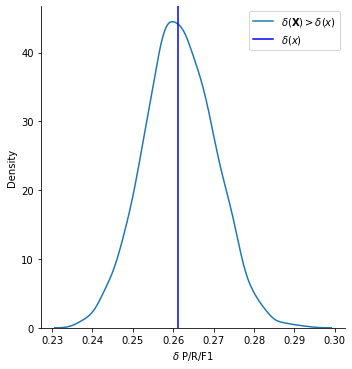

In [ ]:
sns.displot(dx_i,  kind='kde', label = r"$\delta(\mathbf{X})>\delta(x)$")
plt.xlabel(r"$\delta$ P/R/F1")
plt.axvline(x=dx, color='blue', label=r"$\delta(x)$")
plt.legend()
plt.show()